In [16]:
#------ Prologue
import postgkyl as pg
import numpy as np
#import pylab as plt
#import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,4)
import matplotlib.cm as cm
import os, fnmatch, re, sys
#------ add personnal python utilities
home_dir = os.path.expanduser("~")
sys.path.append(home_dir+'/personal_gkyl_scripts/python_utilities')
from classes import Simulation, Species
from utils import *
#------ Path towards the required folders
expdatadir ='/home/ah1032/amd/g0_sim/diagnostics/gk_tcv/tcv_exp_data/' # a possible directory for exp data
g0simdir   = home_dir+'/g0_sim/'        # This is the main directory of g0 simulations
simname    = '48x32x16x16x6_nunifvg'    # This is the name of the simulation
simdir     = 'gk_tcv_posD_iwl_3x2v_AH/' # This is the simulation directory relative to the g0sim
fileprefix = 'gk_tcv_posD_iwl_3x2v_D02' # This is the prefix before the '-*.gkyl'
wkdir      = 'wk/'                      # This is where the .gkyl files sit relatively to the sim dir
#----- some parameters of the simulation
#----- physical quantities
simulation = Simulation()
simulation.set_phys_param(
    B_axis = 1.4,           # Magnetic field at magnetic axis [T]
    eps0 = 8.854e-12,       # Vacuum permittivity [F/m]
    eV = 1.602e-19,         # Elementary charge [C]
    mp = 1.673e-27,         # Proton mass [kg]
    me = 9.109e-31,         # Electron mass [kg]
)
simulation.set_geom_param(
    R_axis      = 0.8727315068,         # Magnetic axis major radius
    Z_axis      = 0.1414361745,         # Magnetic axis height
    R_LCFSmid   = 1.0968432365089495,   # Major radius of LCFS at the midplane
    a_shift     = 0.25,                 # Parameter in Shafranov shift
    kappa       = None,                 # Elongation factor
    delta       = None,                 # Triangularity factor
    q0          = None,                 # Safety factor
    x_LCFS      = 0.04                  # position of the LCFS (x_inner)
)

# Define the species
ion = Species(name='ion',
              m=2.01410177811*simulation.phys_param.mp, # Ion mass
              q=simulation.phys_param.eV,               # Ion charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
elc = Species(name='elc',
              m=simulation.phys_param.me, 
              q=-simulation.phys_param.eV, # Electron charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
simulation.add_species(ion)
simulation.add_species(elc)

# Setup the data parameters, receipe and normalization of the fields
simulation.set_data_param(
    expdatadir = expdatadir, g0simdir = g0simdir, simname = simname, 
    simdir = simdir, fileprefix = fileprefix, wkdir = wkdir, 
    species = simulation.species)

# Load metric coefficients, magnetic field
simulation.geom_param.load_metric(simulation.data_param.fileprefix)

# Check available frames of the ES potential
tfs = find_available_frames(simulation,'field')
print(tfs)

#---- Set up normalization and units
simulation.normalize('t','mus')
simulation.normalize('x','minor radius')
simulation.normalize('y','Larmor radius')
simulation.normalize('fluid velocities','thermal velocity')
simulation.normalize('temperatures','eV')
simulation.normalize('pressures','beta')
simulation.normalize('energies','MJ')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

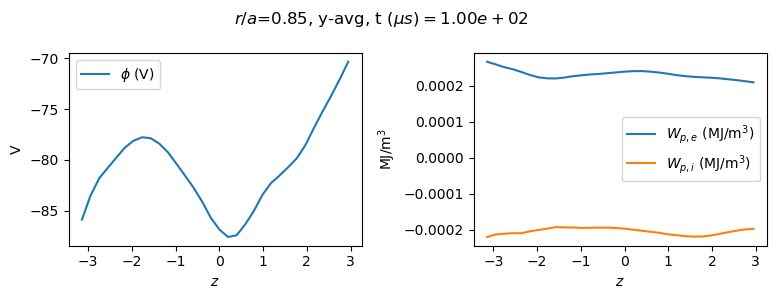

In [28]:
#---------------- Profile time averages
#-- Plane location
# cdirection='x'; ccoords=['avg',0.0]
# cdirection='y'; ccoords=[0.0,0.0]
cdirection='z'; ccoords=[0.85,'avg']
#----------------
plot_1D(simulation,cdirection,ccoords,
                 fieldnames=['phi',['Wpote','Wpoti']],
                 tfs=100
                 )

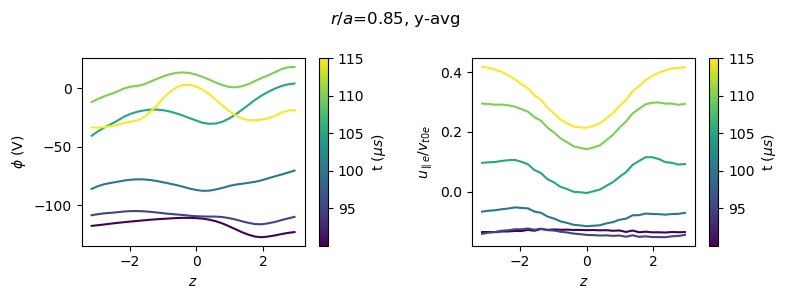

In [39]:
#---------------- Space-time diagrams
#-- Plane location
# cdirection='x'; ccoords=[0.0,0.0]
# cdirection='y'; ccoords=[0.0,0.0]
cdirection='z'; ccoords=[0.85,'avg']
#----------------
plot_1D_time_evolution(simulation,cdirection,ccoords,
                       fieldnames=['phi','upare'],
                       twindow    = [90, 95, 100, 105, 110, 115],     # time window to plot
                       space_time = False,    # plot as space time diagram
                       )

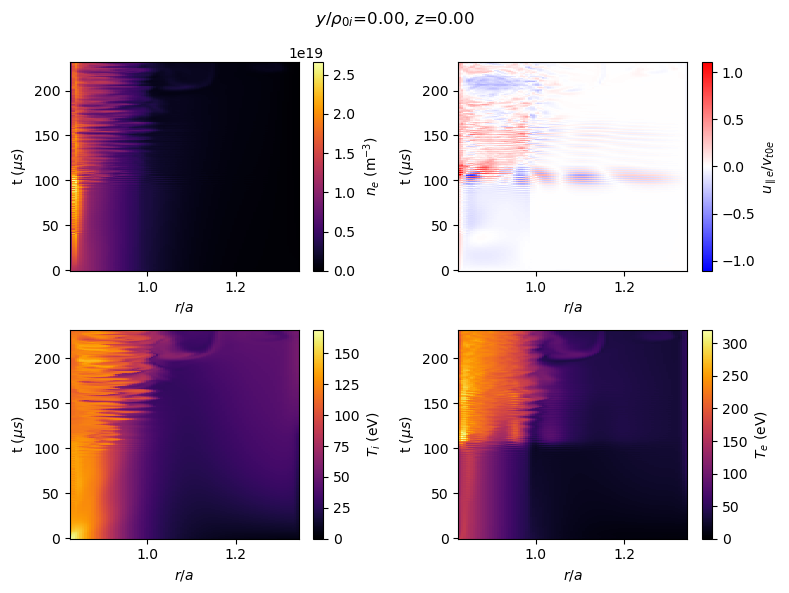

In [44]:
#---------------- Space-time diagrams
#-- Plane location
cdirection='x'; ccoords=[0.0,0.0]
# cdirection='y'; ccoords=[0.0,0.0]
# cdirection='z'; ccoords=[0.045,'avg']
#----------------
plot_1D_time_evolution(simulation,cdirection,ccoords,
                       fieldnames = ['ne','upare','Ti','Te'], # field to plot (4 moments if nothing)
                     #   fieldnames = ['Wtote','Wtoti','Wpote','Wpoti'], # field to plot (4 moments if nothing)
                       twindow    = tfs[:],     # time window to plot
                       space_time = True,    # plot as space time diagram
                       )

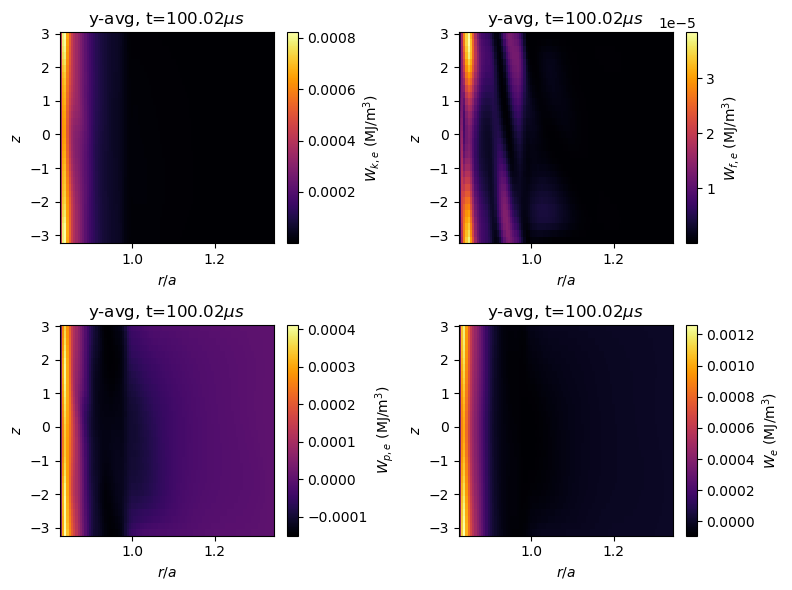

In [19]:
#---------- 2D cut plot
#-- choose min and max time frames and cut location
cplane='xz'; ccoord='avg'
plot_2D_cut(simulation, cplane, ccoord, 
            tf = 100, 
            fieldnames = ['Wkine','Wflue','Wpote','Wtote'],
            # fieldnames = ['Ti','Te','ne','phi'],
            # cmap = 'bwr',
            # ylim = [-3.4,-2]
            )

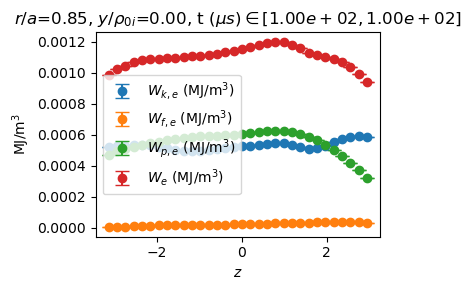

In [20]:
#---------------- Profile time averages
#-- Plane location
# cdirection='x'; ccoords=['avg',0.0]
# cdirection='y'; ccoords=[0.0,0.0]
cdirection='z'; ccoords=[0.85,0.0]
#----------------
plot_1D_time_avg(simulation,cdirection,ccoords,
                 fieldnames=[['Wkine','Wflue','Wpote','Wtote']],
                 tfs=tfs[100]
                 )

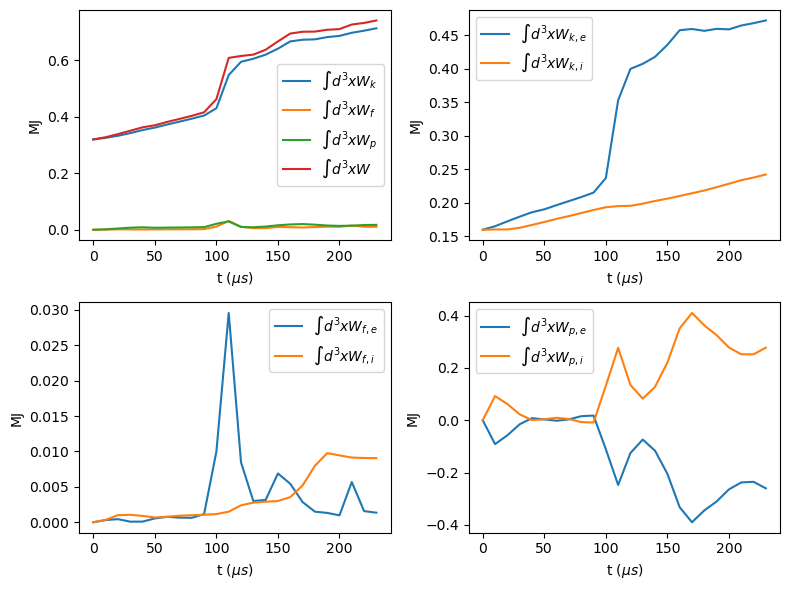

In [21]:
#---- Comput and plot volume integral quantities (energies)
plot_volume_integral_vs_t(simulation,
                          [['Wkin','Wflu','Wpot','Wtot'],
                           ['Wkine','Wkini'],
                           ['Wflue','Wflui'],
                           ['Wpote','Wpoti']],
                          tfs=tfs[::10])

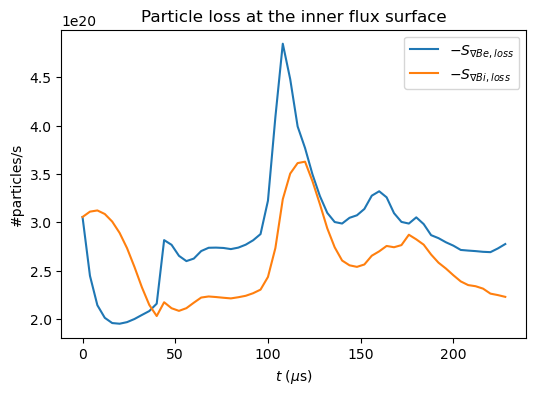

In [22]:
#---- Compute particle loss due to fluctuations over time in the simulation
# (this does not depend on the srcGB parameters)
twindow = tfs
GBloss_i_t, time = simulation.get_GBloss_t(
    spec    = ion,
    twindow = twindow[::4],
    ix      = 0)

GBloss_e_t, time = simulation.get_GBloss_t(
    spec    = elc,
    twindow = twindow[::4],
    ix      = 0)

#--- Compare the source and loss along time
plt.plot(time,[-g for g in GBloss_e_t],label=r'$-S_{\nabla B e, loss}$')
plt.plot(time,[-g for g in GBloss_i_t],label=r'$-S_{\nabla B i, loss}$')
plt.ylabel(r'#particles/s')
plt.xlabel(r'$t$ ($\mu$s)')
plt.title('Particle loss at the inner flux surface')
plt.legend()

In [23]:
#---------- 2D cut movie
#-- choose min and max time frames and cut location
cplane='xy'; ccoord=0.0
make_2D_movie(simulation, cplane, ccoord, 
            tfs = tfs[::10], 
            fieldname = 'Te',            
            # cmap = 'bwr'
            # clim=[0, 200],
            )

movie movie_Te_z=0.00.gif created.


In [24]:
if False:
    #---------------- 2D vpar x plots
    # Simulation frame
    tf = 0
    # Data to plot
    spec = elc
    #spec = ion
    yf = 0.0
    zf = 0.0
    mf = 0.0
    #----------------

    fname = simulation.get_filename('f'+spec.nshort,tf)
    data = pg.data.GData(fname)
    dg = pg.data.GInterpModal(data,1,'ms')
    dg.interpolate(0,overwrite=True)
    pg.data.select(data, z1=yf, z2=zf, z4=mf, overwrite=True)
    pg.output.plot(data, yscale=1./spec.vt,
                title=r"y=%2.2f, z=%2.2f, $\mu$=%2.2f, t=%2.2e (s)"%(yf,zf,mf,data.ctx['time']),
                contour=False,diverging=False, xshift=-x_LCFS,
                xlabel=r'$R-R_{lcfs}\,(m)$',ylabel=r'$v_\parallel/v_{th%s}$'%spec.nshort,
                clabel=r'$f_{%s}$'%spec.nshort);

In [25]:
if False:
    #---------------- 2D mu x plots
    # Simulation frame
    tf = 0
    # Data to plot
    spec = elc
    #spec = ion
    yf = 0.0
    zf = 0.0
    vf = 0.0
    #----------------

    fname = simulation.get_filename('f'+spec.nshort,tf)
    data = pg.data.GData(fname)
    dg = pg.data.GInterpModal(data,1,'ms')
    dg.interpolate(0,overwrite=True)
    pg.data.select(data, z1=yf, z2=zf, z3=vf, overwrite=True)
    pg.output.plot(data, yscale=1./spec.mu0,
                title=r"y=%2.2f, z=%2.2f, $\mu$=%2.2f, t=%2.2e (s)"%(yf,zf,mf,data.ctx['time']),
                contour=False,diverging=False, xshift=-x_LCFS,
                xlabel=r'$R-R_{lcfs}\,(m)$',ylabel=r'$\mu B/T_{%s}$'%spec.nshort,
                clabel=r'$f_{%s}$'%spec.nshort);